왓챠 리뷰 분석

[1] 모듈로딩 및 데이터셋 불러오기

In [166]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch import nn
from sklearn.metrics import confusion_matrix

In [167]:
FILE_PATH = r'C:\baekjoon-solutions\자연어처리\watcha_reviews_final3.csv'

In [168]:
df= pd.read_csv(FILE_PATH)

In [169]:
df.head(5)

,평점,리뷰,긍정
0,4.0,또 또 나만 재밌지,1
1,1.5,1화부터 변요한이 고등학생역으로 나오는데 도저히 몰입이 안된다... 동안인건 알겠는...,0
2,4.0,"동명소설 원작, 탄탄한 시나리오 기반에\n주, 조연들의 현실적 실감 연기,\n그리고...",1
3,3.0,"쫀득한 이야기를 밀도 있게 담아내지 못한\n속도, 미장센, 연기, 음악에 대한 아쉬움.",0
4,3.5,본인과 가족의 인생을 다 파탄낸\n가해자들에게 주먹 한방을 안날리는\n주인공을 보고...,1


In [170]:
import re
# 정규식을 사용하는 함수
def re_text(text):

    text = re.sub(r'[^\n가-힇\s]', '', text)  
    text = re.sub(r'\s+', ' ', text)
    return text.strip()  # 앞뒤 공백제거

In [171]:
df['리뷰'] = df['리뷰'].apply(re_text)

In [172]:
df['리뷰']

0                                               또 또 나만 재밌지
1        화부터 변요한이 고등학생역으로 나오는데 도저 몰입이 안된다 동안인건 알겠는데 고등학...
2        동명소설 원작 탄탄한 시나리오 기반에 주 조연들의 현실적 실감 연기 그리고 치밀한 ...
3              쫀득한 이야기를 밀도 있게 담아내지 못한 속도 미장센 연기 음악에 대한 아쉬움
4        본인과 가족의 인생을 다 파탄낸 가해자들에게 주먹 한방을 안날리는 주인공을 보고 있...
                               ...                        
14612            제작진이 만든 계급 전쟁을 기꺼이 요리 전쟁으로 승화시키는 대단한 요리사들
14613                                    무물코기 에드워드 리님 귀여우셔
14614           왜 하루전에 인터뷰로 깨방정을 오랜만에 순수하고 공정한 경쟁이 재밌고 좋았다
14615                         몰아치는 연출력과 스케일 예능에서 드라마 작법을 씀
14616                 최근 나온 한국예능중 가장 확실하고 압도적인 퍼포먼스를 보여주었다
Name: 리뷰, Length: 14617, dtype: object

In [173]:
idx = df[df['리뷰'].str.contains('스포일러가 있어요')].index
df = df.drop(idx)

In [174]:
df = df.drop('평점',axis=1)

In [175]:
df['긍정'].value_counts()

긍정
1    7429
0    6465
Name: count, dtype: int64

In [176]:
# train, test 나누기
train = df.sample(frac=0.9, random_state=42) # 랜덤으로 90를 선택
test = df.drop(train.index)                  # 트레인을 삭제해서 비율을 train : test = 9: 1

print(train.head(5))
print('Training Data Size : ', len(train))
print("Testing Data Size : ", len(test))

                                                      리뷰  긍정
11163       마지막화 마지막 장면은 감 말하건데 내가 본 최고의 엔딩이었다 네마리의 용이라니   1
7713                           난 아서가 아니라 조커를 보러 영화관에 온건데   1
9470                                                  쓰읍   1
12729  뮤지컬땜에 항상 궁금했는데 일단 내용을 알 수 있어서 그걸로도 오케이 댄버스부인이 ...   0
9274   이 순간 따뜻한 위로와 관심이 필요합니다 꼭 주인공남녀가 조커와 할리가 아니어도 성...   1
Training Data Size :  12505
Testing Data Size :  1389


In [177]:
# 데이터 토큰화 및 단어 사전 구축
from konlpy.tag import Okt
from collections import Counter

## 단어사전을 만드는 함수
def build_vocab(corpus, n_vocab, special_tokens): #n_vocab은 최대 사용할 단어개수
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab): # 가장 많이 등장한 순서대로 상위 n_vocab개의 단어 반환
        vocab.append(token)
    return vocab


In [178]:
## 불용어 리스트 불러오는 함수
STOP_PATH = 'kor_stopwords.txt'

def make_stopwords(STOP_PATH):
    with open(STOP_PATH, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines() # 문장단위로
    return set(stopwords)       


In [179]:
stopwords = make_stopwords(STOP_PATH)

In [180]:
tokenizer = Okt()
train_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords ] for review in train.리뷰]   
test_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords] for review in test.리뷰]

vocab = build_vocab(corpus=train_tokens, n_vocab=10000, special_tokens=["<pad>", "<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)} 
id_to_token = {idx: token for idx, token in enumerate(vocab)} 

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '영화', '사람', '사랑', '생각', '잘', '할', '웹툰', '김수현']
10002


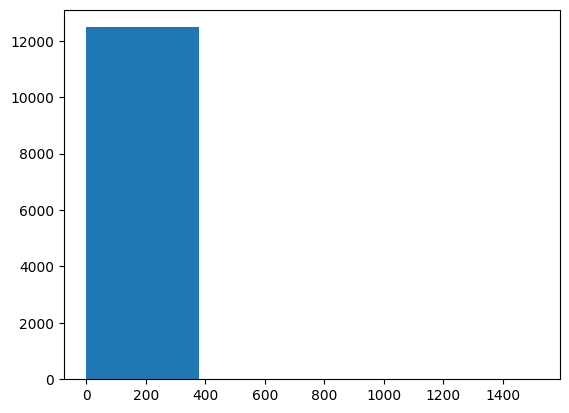

In [240]:
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen,bins=4)
plt.show()

In [182]:
# 못걸러진 불용어 찾기
all_tokens = [token for tokens in train_tokens for token in tokens]
token_counts = Counter(all_tokens)
frequencies = list(token_counts.values())

token_counts.most_common(60)

[('영화', 3069),
 ('사람', 1007),
 ('사랑', 886),
 ('생각', 798),
 ('잘', 776),
 ('할', 722),
 ('웹툰', 693),
 ('김수현', 671),
 ('원작', 662),
 ('노래', 620),
 ('플', 601),
 ('렉', 594),
 ('드라마', 587),
 ('아서', 585),
 ('배우', 544),
 ('연기', 538),
 ('이야기', 528),
 ('뮤지컬', 526),
 ('점', 514),
 ('한다', 487),
 ('보고', 484),
 ('진짜', 464),
 ('작품', 462),
 ('시즌', 452),
 ('요리', 444),
 ('보다', 439),
 ('없는', 434),
 ('장면', 421),
 ('감독', 415),
 ('느낌', 410),
 ('캐릭터', 410),
 ('같은', 394),
 ('연출', 386),
 ('그냥', 380),
 ('스토리', 380),
 ('편', 375),
 ('없다', 368),
 ('대한', 353),
 ('관객', 352),
 ('시작', 341),
 ('볼', 340),
 ('되는', 336),
 ('건', 335),
 ('아닌', 333),
 ('정도', 332),
 ('보는', 331),
 ('하게', 328),
 ('모든', 323),
 ('성', 314),
 ('이렇게', 313),
 ('때문', 294),
 ('처럼', 292),
 ('모습', 291),
 ('현실', 286),
 ('부분', 285),
 ('듯', 282),
 ('재미', 280),
 ('재희', 263),
 ('마지막', 261),
 ('다시', 257)]

In [183]:
## 정수 인코딩 및 패딩
import numpy as np
# 패딩까지 해주는 함수
def pad_sequences(sequences, max_length, pad_value):  
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length] 
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length   
        result.append(padded_sequence)
    return np.asarray(result)   

In [184]:
unk_id = token_to_id["<unk>"]   
train_ids = [[token_to_id.get(token, unk_id) for token in review] for review in train_tokens]  
test_ids = [[token_to_id.get(token, unk_id) for token in review] for review in test_tokens]

max_length = 50
pad_id = token_to_id["<pad>"]   
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

[  60   60   29    1   89  354 3354 2144  730    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[ 327  261  108 5912  282 1635    1 1202 9950   71   22 1254    1 3707
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [185]:
train_ids

array([[  60,   60,   29, ...,    0,    0,    0],
       [  65,  160,   90, ...,    0,    0,    0],
       [8220,    0,    0, ...,    0,    0,    0],
       ...,
       [ 541,   89,   64, ...,    0,    0,    0],
       [ 505,  139,  253, ...,    0,    0,    0],
       [  71, 3679, 6685, ...,    0,    0,    0]])

In [186]:
## 데이터로더
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.긍정.values, dtype=torch.float32)
test_labels = torch.tensor(test.긍정.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [187]:
for feature, label in train_loader:
    print(feature)
    print(label)
    break

tensor([[ 531,   19,  364,   11,  657,    1,  123,  143,  289,  610,  164,  906,
          160,   45, 2746,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  73, 4808, 1119,   92,  165, 7038,  220,  426, 6916,   39,  465, 9403,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2, 2282, 2283, 1105,   14,  297,  284,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [188]:
# 문장 분류하는 모델
class SentenceClassifier(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers, n_classes ,dropout=0.5, bidirectional=True, model_type="lstm"):
        super().__init__()  # 부모클래스 상속

        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim, padding_idx=0)

        # rnn모델 일 경우
        if model_type == 'rnn':
            self.model = nn.RNN(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )
        # lstm모델 일 경우
        elif model_type == 'lstm':
            self.model = nn.LSTM(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )

        # bidirectional은 양방향성을 의미하는 파라미터
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, n_classes)   # 양방향일때 타임스탭에서 양방향의 정보(순방향,역방향)의 출력들을 결합하여 분류기에 전달
        else:
            self.classifier = nn.Linear(hidden_dim, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings) 
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [190]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [191]:
## 손실 함수와 최적화 함수 정의
from torch import optim
LR = 0.001
n_vocab = len(token_to_id)   # 단어사전의 크기
hidden_dim = 128     # 은닉 사태의 크기
embedding_dim = 128   #임베딩 벡터의 차원 128차원으로 사용
n_layers = 2     # 2층
n_classes = 1 # 2진 분류라 1

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers, n_classes=n_classes).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)   
optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

모델학습

In [192]:
# 모델 학습하는 함수
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%interval == 0:
            print(f'Train Loss {step} : {np.mean(losses)}')

In [193]:
# 모델 테스트하는 함수
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):   
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)  
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits)>.5  
        corrects.extend(torch.eq(yhat, labels).cpu().tolist())        

        val_loss = np.mean(losses)
        val_accuracy = np.mean(corrects)

    print(f"Val Loss : {val_loss}, Val Accuracy : {val_accuracy}")
    return val_loss


In [194]:
epochs = 100
interval = 500   

for epoch in range(epochs):
    print(f'epoch : {epoch}')
    train(classifier, train_loader, criterion, optimizer, device, interval)
    val_loss = test(classifier, test_loader, criterion, device)
    scheduler.step(val_loss)

epoch : 0
Train Loss 0 : 0.6939022541046143


Train Loss 500 : 0.6907760848304231
Val Loss : 0.6901656170000975, Val Accuracy : 0.5557955363570914
epoch : 1
Train Loss 0 : 0.6778349876403809
Train Loss 500 : 0.6863895342973416
Val Loss : 0.7347057732357376, Val Accuracy : 0.556515478761699
epoch : 2
Train Loss 0 : 0.7856537103652954
Train Loss 500 : 0.6768698128397593
Val Loss : 0.7062810474428637, Val Accuracy : 0.5485961123110151
epoch : 3
Train Loss 0 : 0.6648533940315247
Train Loss 500 : 0.6728623502268762
Val Loss : 0.6842735354927765, Val Accuracy : 0.5392368610511159
epoch : 4
Train Loss 0 : 0.5819196701049805
Train Loss 500 : 0.6223550921904588
Val Loss : 0.6239110882254852, Val Accuracy : 0.6630669546436285
epoch : 5
Train Loss 0 : 0.5843283534049988
Train Loss 500 : 0.527937169441444
Val Loss : 0.6326474182564636, Val Accuracy : 0.67170626349892
epoch : 6
Train Loss 0 : 0.40555834770202637
Train Loss 500 : 0.4315222952507451
Val Loss : 0.7654069812818506, Val Accuracy : 0.6724262059035278
epoch : 7
Train Loss 0 : 0.42385

In [195]:
torch.save(classifier, f'best_model.pth')

In [196]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model=torch.load('best_model.pth', weights_only=False).to(device)

In [235]:
new_reviews = ["너무 폭력적이여서 재미가 없었어"]

In [236]:
new_reviews = [re_text(review) for review in new_reviews]
new_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords] for review in new_reviews]
new_ids = [[token_to_id.get(token, unk_id) for token in tokens] for tokens in new_tokens]
new_ids_padded = pad_sequences(new_ids, max_length, pad_id)
new_ids_tensor = torch.tensor(new_ids_padded).to(device)

In [237]:
## 예측
model.eval()
with torch.no_grad():
    outputs = model(new_ids_tensor)
    predictions = torch.sigmoid(outputs)

# 9. 예측 결과 출력 (0.5 이상이면 긍정, 미만이면 부정)
for i, review in enumerate(new_reviews):
    prediction = 1 if predictions[i] >= 0.5 else 0
    print(f"리뷰: {review}")
    print(f"예측된 결과: {'긍정' if prediction == 1 else '부정'}")

리뷰: 너무 폭력적이여서 재미가 없었어
예측된 결과: 긍정


In [200]:
import pickle
# 단어 사전 저장
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.


In [201]:
import pickle

# 단어 사전 불러오기
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

print("단어 사전이 불러와졌습니다.")
print(vocab)

단어 사전이 불러와졌습니다.
['<pad>', '<unk>', '영화', '사람', '사랑', '생각', '잘', '할', '웹툰', '김수현', '원작', '노래', '플', '렉', '드라마', '아서', '배우', '연기', '이야기', '뮤지컬', '점', '한다', '보고', '진짜', '작품', '시즌', '요리', '보다', '없는', '장면', '감독', '느낌', '캐릭터', '같은', '연출', '그냥', '스토리', '편', '없다', '대한', '관객', '시작', '볼', '되는', '건', '아닌', '정도', '보는', '하게', '모든', '성', '이렇게', '때문', '처럼', '모습', '현실', '부분', '듯', '재미', '재희', '마지막', '다시', '마음', '이라는', '라고', '난', '많이', '세상', '이해', '없이', '레베카', '주인공', '해서', '인물', '맛', '님', '매력', '줄', '내용', '위', '인간', '별', '이고', '가장', '셰프', '좋은', '존재', '보면', '이유', '최고', '아니라', '전작', '함', '처음', '전개', '계속', '엔', '인데', '흥수', '환상', '사회', '역시', '좋았다', '몰입', '전', '사실', '자체', '프로그램', '인생', '하면', '이라', '친구', '보기', '인지', '음식', '했던', '대사', '많은', '근데', '순간', '이나', '감동', '개인', '기대', '않은', '결말', '않는', '그렇게', '은밀', '하다', '눈', '기억', '서사', '표현', '감정', '서로', '했는데', '광기', '있어', '약점', '의도', '남자', '나를', '않고', '한국', '하기', '만든', '별로', '남', '김고은', '초반', '대중', '큰', '앞', '할리퀸', '삶', '나도', '좋다', '예능', '망상', '서가', '없고', '피닉스', '번'

In [202]:
import seaborn as sns

# 모델 테스트하고 혼동 행렬을 시각화하는 함수
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()
    
    # 실제 레이블과 예측 값을 저장할 리스트
    all_labels = []
    all_predictions = []

    for step, (input_ids, labels) in enumerate(datasets):   
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)  
        loss = criterion(logits, labels)
        losses.append(loss.item())

        # 예측 값과 실제 값을 리스트에 추가
        yhat = torch.sigmoid(logits) > 0.5  
        all_labels.extend(labels.cpu().tolist())  # 실제 레이블
        all_predictions.extend(yhat.cpu().tolist())  # 예측 값

        corrects.extend(torch.eq(yhat, labels).cpu().tolist())

    val_loss = np.mean(losses)
    val_accuracy = np.mean(corrects)

    print(f"Val Loss : {val_loss}, Val Accuracy : {val_accuracy}")

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_predictions)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return val_loss

Val Loss : 1.2650047916833354, Val Accuracy : 0.6364290856731462


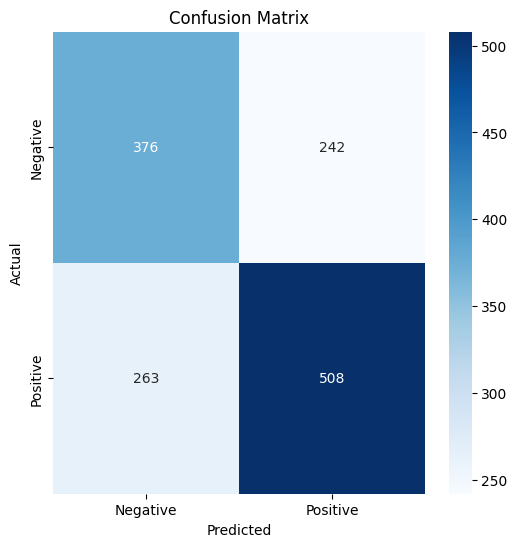

In [203]:
val_loss = test(classifier, test_loader, criterion, device)